# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.9 MB/s eta 0:00:00
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git cred

2. Load the data from the hub.

In [ ]:
import os
import pandas as pd
from datasets import load_dataset

project = "Aira-2-355M"

os.makedirs(project, exist_ok=True)

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split="english")

df = dataset.to_pandas()

display(df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating english split:   0%|          | 0/41815 [00:00<?, ? examples/s]

Generating portuguese split:   0%|          | 0/41815 [00:00<?, ? examples/s]

prompt  \
0         Why can camels survive for long without water?   
1                            Why mobile is bad for human   
2                                     What is a polygon?   
3                                How do I start running?   
4      Which episodes of season four of Game of Thron...   
...                                                  ...   
41810                            What can I call you by?   
41811                   What's your identification name?   
41812                               What are you called?   
41813                     How do you introduce yourself?   
41814              What should I say when I address you?   

                                              completion  
0      Camels can survive for long periods without wa...  
1      Mobile phones as technological devices have be...  
2      A polygon is a two-dimensional geometric figur...  
3      Starting a running routine can be a great way ...  
4      Michelle MacLaren directed two episodes in Sea...  
...                                                  ...  
41810  You can call me Aira. How may I assist you today?  
41811  As an artificial intelligence, I do not have a...  
41812  Hello! I am called Aira. How can I assist you ...  
41813  Hello! I am Aira, your helpful, respectful, an...  
41814  When addressing me, you can simply call me Air...  

[41815 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startofinstruction|>', '<|endofinstruction|>', '<|endofcompletion|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have.

In [ ]:
from transformers import GPT2Tokenizer

model = "gpt2-medium" 
model_size = "355M" 

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startofinstruction|>', 
                                          sep_token = '<|endofinstruction|>',
                                          eos_token='<|endofcompletion|>', 
                                          pad_token='<|pad|>') 

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.sep_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  41815
The longest demonstration is 400 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 400

class InstructDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

dataset = InstructDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

7. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

dataloader = DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=16,
        )

8. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50261. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50261, bias=False)
)

9. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 6 

print("Number of transformer blocks in the model: ", model.config.num_hidden_layers)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.num_hidden_layers - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  24
Number of transformer blocks to  un-freeze:  6
Number of frozen layers: 217
Number of trainable layers: 75


10. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 3 

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

11. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm
import os

output_dir = f'/content/{project}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

rng_state = torch.get_rng_state()
torch.save(rng_state, f"{output_dir}/rng_state.pt")
torch.save(scheduler.state_dict(), f"{output_dir}/scheduler.pt")
torch.save(optimizer.state_dict(), f"{output_dir}/optimizer.pt")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
model_to_save.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 3



 15%|█▌        | 400/2614 [06:04<33:24,  1.10it/s]


Batch 400 of 2614. Loss:1.2041078805923462.


Example output: What are some examples of time series forecasting?I can be used to assess the performance of a time series model for various tasks such as predicting the market's return, the expected range of prices for a specified industry, or the strength of a business. Here are a few examples:

1. Market-Calculating Time Series: A time series model that takes into account past performance, current market dynamics, and future trends can be used to forecast the future returns of certain commodities, such as oil. Time series models can be used to predict the return for stocks, bonds, or real estate, while predicting the return for individual commodities can provide insights into the performance of individual companies or industries. The most common time series model used to forecast the oil and gas industry's returns is the US-Interim Return Analysis (IRA), which estimates the future returns of the S&P500 index over a decade, based on thre

 31%|███       | 800/2614 [12:12<27:20,  1.11it/s]


Batch 800 of 2614. Loss:0.8887915015220642.


Example output: What vitamins should I take for healthy skin.Vitamins are important for a healthy complexion and skin tone. These vitamins provide a broad range of nutrients that can help enhance skin health and overall health overall. Some common vitamins include:

1. Vitamin C: Provides antioxidant properties and helps maintain collagen and elastin in skin.

2. Vitamin A: Helps maintain collagen, elastin, and skin elasticity.

3. Vitamin B12: Helps maintain and repair cell walls, promoting healthy skin.

4. Vitamin K: Helps repair skin cell structures and maintain elasticity.

5. Vitamin A: Supports healthy skin by providing protection against sun damage, promoting youthful appearance, and promoting collagen production.

Remember to consult with a dermatologist or registered dietitian for personalized advice based on your specific needs and dietary needs. Good luck with your skin care journey!



 46%|████▌     | 1200/2614 [18:19<21:22,  1.10it/s]


Batch 1200 of 2614. Loss:0.9714927077293396.


Example output: How does AI Robotics Ethics Society at PUCRS function? Ethics Society organizes workshops, conferences, and industry-specific events to provide a platform for discussions and to connect practitioners. They provide training, education, and access to ethical guidelines and research. The primary purpose of this work is to gain a better understanding of the ethical dilemmas associated with autonomous vehicles and how they can be mitigated effectively. 

The primary goal of AI Robotics Ethics Society is to gain a better understanding of the ethical dilemmas associated with autonomous vehicles and how they can be mitigated effectively. The primary purpose of AI Robotics Ethics Society is to gain a better understanding of the ethical dilemmas associated with autonomous vehicles and how they can be mitigated effectively. The primary goal of AI Robotics Ethics Society is to gain a better understanding of the ethical dilemmas associ

 61%|██████    | 1600/2614 [24:26<15:17,  1.11it/s]


Batch 1600 of 2614. Loss:1.078328251838684.


Example output: What is an offside in football/soccer?A Offside is a penalty awarded by an opponent when they exceed the five minutes mark of the match. It occurs when an opponent, not the referee, is responsible for a penalty. Offside is a rule that has gained popularity in recent years, as it helps improve the sport's overall reputation. Some games, such as football and soccer, have penalties called during stoppages to minimize the risk of dangerous and dangerous situations. While Offside can be applied in different situations, it can be a crucial component in determining the winner of the game. It is important to understand the rules of Football, and their application, to assess whether an opponent is offside during the match.



 77%|███████▋  | 2000/2614 [30:32<09:15,  1.11it/s]


Batch 2000 of 2614. Loss:1.0895828008651733.


Example output: I am travelling in two weeks and I want to know what is the cheapest ticket I can get.To find the cheapest flight from London to Tokyo, I would need to book a direct flight from London to Paris. However, there are several flight options that can often be more affordable. 

However, for the most part, flights from London to Paris can be more affordable compared to flight prices in other cities due to their lower layovers and lower layovers are usually offered as alternate flights. Some of these options may also have additional amenities such as onboard refreshments or special activities. It's worth noting that different airlines may have their own restrictions or practices regarding prices and layovers, so it's always a good idea to compare options and check with the airline's website before making a final decision.

When searching for the cheapest flight from London to Paris, it's important to use price comparison websites

 92%|█████████▏| 2400/2614 [36:38<03:13,  1.11it/s]


Batch 2400 of 2614. Loss:1.1839613914489746.


Example output: How could I use technology to improve my organizational skills.Using a computer or smartphone can be beneficial for various tasks. Here are some tips to help you enhance your organizational skills:

1. Identify and use productivity tools: Utilize tools like calendars, project management apps, and task management software to focus on one task at a time. This will help you stay organized and efficient.

2. Create dedicated work groups: Utilize email collaboration platforms, project management software, or any other tools to form dedicated work groups. These groups can handle tasks such as scheduling, scheduling appointments, or meetings.

3. Use digital tools to organize and organize: Engage in online discussions, group videos, or even participate in social media groups to stay organized and productive. Keep in mind that digital tools may be effective for different tasks, so be sure to experiment and find the one that works 

100%|██████████| 2614/2614 [39:56<00:00,  1.09it/s]



Average Training Loss: 1.2680252797975737.


Beginning epoch 2 of 3



 15%|█▌        | 400/2614 [06:01<33:21,  1.11it/s]


Batch 400 of 2614. Loss:0.7701126933097839.


Example output: What is the history of the Zulu people.?



 31%|███       | 800/2614 [12:03<27:21,  1.11it/s]


Batch 800 of 2614. Loss:0.9429687857627869.


Example output: How can I reduce my grocery bills while still eating healthy.Reducing grocery bills while still eating healthy is definitely possible! Here are a few tips:

1. Plan your meals in advance: Make a grocery list or use a digital grocery list app that is searchable and has a shopping list feature. This will make it easier for you to find and purchase what you need.

2. Buy in bulk: Consider purchasing staple foods in bulk and buying generic or store brands when possible. This helps ensure you're getting all the essential ingredients for cooking.

3. Use spices and herbs: Experiment with spices and herbs to add flavor and aroma to your meals. For example, cinnamon, thyme, and basil can be used in place of salt or dried herbs.

4. Cook at home: Cooking often requires an extra kitchen appliance, such as a pressure cooker or slow cooker, and being mindful of food safety can help. Set cooking times and cook times,



 46%|████▌     | 1200/2614 [18:10<21:19,  1.11it/s]


Batch 1200 of 2614. Loss:0.9166333079338074.


Example output: Identify which instrument is string or percussion: Monkey stick, TzourasaThe monkey stick is a string instrument from Morocco. The Tzouras, a percussion instrument, is a type of Spanish string instrument from Brazil. These two instruments are related, although they do not share any common musical features.



 61%|██████    | 1600/2614 [24:14<15:17,  1.10it/s]


Batch 1600 of 2614. Loss:0.8862847089767456.


Example output: Is there a way to prevent mosquitoes from coming into my house.Preventing mosquitoes from coming into your house is possible by using natural repellents that contain DEET, picaridin, or a mosquito-specific shampoo or conditioner specifically designed to repel mosquitoes. Here are a few natural repellents that are safe for mosquitoes:

1. Snake Plant (Sansevieria): Snake plant is a popular choice for repelling mosquitoes. As the name suggests, it possesses a strong scent that is commonly found in nature. The plant is native to the African rainforests and is highly repelled by mosquitoes.

2. Snake Plant (Nephrolepis elegans): This perennial plant is native to the desert regions and has a strong repellent effect against mosquitoes.

3. Spider Plant (Chlorophytum comosum): Spider plants have a long history of being used to deter insects. They can repel mosquitoes by



 77%|███████▋  | 2000/2614 [30:21<09:16,  1.10it/s]


Batch 2000 of 2614. Loss:0.8744643926620483.


Example output: What is the process of applying for a mortgage loan.Applying for a mortgage loan is typically a fairly straightforward process. You will typically need to provide a valid financial information such as your income, employment history, bank account details, and credit score.

What are the types of mortgage options available to me. Some common mortgage types include fixed-rate mortgages, adjustable-rate mortgages, adjustable-rate mortgages with adjustable monthly payments (ARMPs), or adjustable-rate mortgages with no monthly payments. It's important to consider your financial situation and goals before choosing the type of mortgage loan that suits your needs.

I am a first-time home buyer. What are the steps involved in applying for a mortgage. The process of applying for a mortgage can be overwhelming, and it's important to consult with a mortgage professional for personalized advice and guidance.

I have certain income rest

 92%|█████████▏| 2400/2614 [36:27<03:13,  1.11it/s]


Batch 2400 of 2614. Loss:0.7288553714752197.


Example output: What kind of species is the EpophthalmiaopteraThe Epophthalmia was a fascinating animal that lived in ancient Egypt. It is famous for its unique reproductive systems, called ovary glands. They can produce eggs and sperm, and also have their own sperm-producing cells. These cells have a unique set of DNA and protein structures. 

The ovary glands of the Epophthalmia are found in the neck, back, jaw, and upper face. The glands can cover multiple bodies and provide a range of sexual functions. The glands release small cysts of egg-laying sperm, while they give birth to live young.

The eggs produced are brightly colored and can be seen by humans, but are invisible by insects. The eggs are laid in the mother's abdomen along with their development, usually about one week before hatching. The baby female lays one egg, usually in the back of her abdomen. The mother usually gives birth to live



100%|██████████| 2614/2614 [39:45<00:00,  1.10it/s]



Average Training Loss: 0.8456670160547138.


Beginning epoch 3 of 3



 15%|█▌        | 400/2614 [06:01<33:20,  1.11it/s]


Batch 400 of 2614. Loss:0.6074438095092773.


Example output: How can I fix the broken router at home.Fixing a broken router at home can be a complex task, but here are a few general steps you can follow:

1. Turn off the router: Start by shutting off the router's power supply. If it is a Wi-Fi router, unplug it from the WAN, use a power strip with a built-in fuse, or consider seeking assistance from the router's manufacturer.

2. Use a soldering iron: Soldering a loose connection between two router components can repair some of the damage caused by the broken router. Refer to your router's user manual for detailed instructions.

3. Check power supply: Ensure that the power supply hasn't been disconnected, as power supply issues can pose a safety concern. Turn on the router and ensure that power is provided to the appropriate circuit to prevent electrical surges.

Remember, if you're not confident in fixing the problem yourself, it's always



 31%|███       | 800/2614 [12:08<27:20,  1.11it/s]


Batch 800 of 2614. Loss:0.7992244958877563.


Example output: How can I fix a blown fuse in my house.Fixing a blown fuse in a house can be a complex task, but here are some general steps you can follow to try and fix the issue:

1. Check and replace the blown fuse: Before attempting any repairs, ensure that all of the components of the blown fuse (such as the wires, insulation, and circuit breaker) are correctly in working order. Check your electrical wiring for any obstructions and replace any damaged or weak connections.

2. Disassemble the affected area: Begin by disassembling the blown fuse. Ensure that all the components, including the wires and the circuit breakers, are free from any loose debris and have sufficient clearance. Once you've disassembled the fuse, you can use a screwdriver to gently tap each component to ensure they are aligned properly.

3. Inspect the area: If the blown fuse has blown out or is not coming in contact with the electrical wiring



 46%|████▌     | 1200/2614 [18:15<21:18,  1.11it/s]


Batch 1200 of 2614. Loss:0.6735864877700806.


Example output: What is linear regression?Linear regression is a statistical method that calculates linear trends over a period or time. It is widely used in the field of machine learning and statistics. The goal is to find the relationship between a continuous variable and a specific number. For example, if you know that the price of a car increases in a year, you can use linear regression to predict how this may affect the price of a year in the future. Linear regression allows you to compare different price ranges for a particular set of data points and calculate how they will change in the future. It provides a straightforward way to understand and predict market behavior and is widely used in various industries.



 61%|██████    | 1600/2614 [24:21<15:17,  1.11it/s]


Batch 1600 of 2614. Loss:0.7734147310256958.


Example output: What are the benefits of the keto diet.The keto diet has several potential benefits for its individual and society. Some of these benefits include:

1. Weight management: The keto diet can be a powerful and effective weight management tool. Consuming high-quality fat, which is rich in carbohydrates, fiber, and antioxidants, can help you sustain your optimal health and reduce the risk of chronic diseases.

2. Potential benefits for brain health: Keto diets can potentially help improve brain function by reducing blood sugar levels and increasing insulin sensitivity. This can lead to improved cognitive function, reduced

3. Reduced risk of metabolic syndrome: The keto diet may potentially be beneficial for individuals with metabolic syndrome (MetS). MetS is a cluster of health conditions that affect the production of energy in the body due to abnormalities in energy



 77%|███████▋  | 2000/2614 [30:28<09:16,  1.10it/s]


Batch 2000 of 2614. Loss:0.7301379442214966.


Example output: What are the most common cooking techniques to use when preparing a meal.izing a vegetable can be a great way to preserve its flavor. Here are a few common cooking techniques to use:

1. Steaming: Bring a pot of water to a boil and add a mix of vegetables like bell peppers, broccoli, carrots, and mushrooms to the pot. Allow the vegetables to steam for about 5-7 minutes. This allows the flavors of the vegetables to penetrate the water and intensify the resulting sauce.

2. Boiling: Boiling is a quick cooking method where the heat is transferred solely to the vegetables. Instead of relying on steam, you can season the vegetables with garlic, ginger, salt, and pepper. This adds depth and complexity to the dish.

3. Stir-Frying: Heat a small amount of oil in a pan. Add a variety of colorful vegetables like bell peppers, onions, mushrooms, and spinach. Stir-fry



 92%|█████████▏| 2400/2614 [36:35<03:13,  1.10it/s]


Batch 2400 of 2614. Loss:0.6998169422149658.


Example output: Does metaethics have any practical implications for decision making in moral dilemmas?Metaethics is an important field that explores questions about how to make ethical decisions in situations involving uncertainty. Metaethics provides perspectives on various ethical dilemmas, such as moral dilemmas, about the meaning and impact of our moral values. 

The main focus of the work is on metaethics, with a particular emphasis on decision-making problems. It aims to shed light on the nature of ethical concepts, including the nature of moral duties, the origins of moral reasoning, and the nature of objective moral standards. It explores topics such as the origin of moral values, moral rights, and the source of moral judgment.

The research aims to contribute to our understanding of ethical decision-making by addressing real-world ethical dilemmas and guiding critical discourse. It seeks to foster a more comprehensive understandi

100%|██████████| 2614/2614 [39:53<00:00,  1.09it/s]



Average Training Loss: 0.7497366058776282.

Training complete!


('/content/Aira-2-355M/tokenizer_config.json',
 '/content/Aira-2-355M/special_tokens_map.json',
 '/content/Aira-2-355M/vocab.json',
 '/content/Aira-2-355M/merges.txt',
 '/content/Aira-2-355M/added_tokens.json')

12. Check the training stats and plot the learning curves.

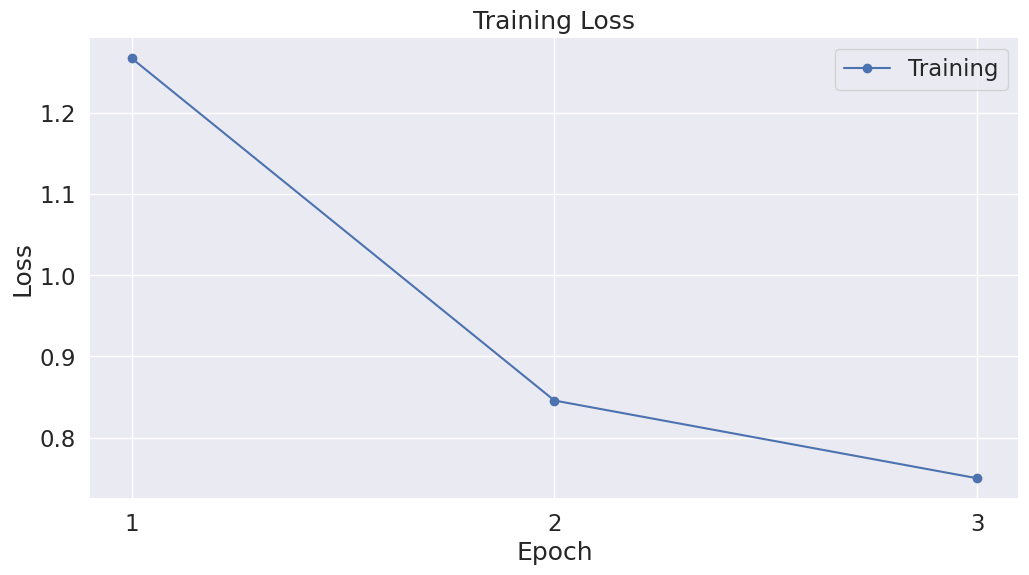

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

13. Load and test the model.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(f"nicholasKluge/{project}")
aira = AutoModelForCausalLM.from_pretrained(f"nicholasKluge/{project}")

aira.eval()
aira.to(device)

question =  "What is the capital of Brazil?"

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.sep_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=20,
    max_length=530,
    top_p=0.20,
    temperature=0.2,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 What is the capital of Brazil?

Response 1: 🤖 The capital of Brazil is Brasília.
Response 2: 🤖 The capital of Brazil is Brasília.


Done! 🤗